In [93]:
%load_ext autoreload
%autoreload 2
import torch

import numpy as np
import matplotlib.pyplot as plt

from deeplift_shap import DeepLiftShap

from diveslowlearnfast.train import helper as train_helper
from diveslowlearnfast.models import SlowFast, load_checkpoint
from diveslowlearnfast.config import Config

import logging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
logging.basicConfig(level=logging.DEBUG)

class DualInputWrapper(torch.nn.Module):
    def __init__(self, model):
        super(DualInputWrapper, self).__init__()
        self.model = model


    def forward(self, xb):
        x_fast = xb[:]
        x_slow = xb[:, :, ::cfg.SLOWFAST.ALPHA]
        input = [x_slow, x_fast]
        return self.model(input)

cfg = Config()
cfg.DATA.DATASET_PATH = '/Users/youritomassen/Projects/xai/data/Diving48/'
cfg.TRAIN.BATCH_SIZE = 24
cfg.DATA.NUM_FRAMES = 8
cfg.DATA.TRAIN_CROP_SIZE = 224
cfg.DATA.TEST_CROP_SIZE = 224
device = torch.device('cpu')
model = SlowFast(cfg)
_, optimiser, train_loader, *_ = train_helper.get_train_objects(cfg, model)
model, *_ = load_checkpoint(model, optimiser, '../misc/checkpoint.pth', device)
model = DualInputWrapper(model)

dl = DeepLiftShap(model)

test_loader = train_helper.get_test_objects(cfg)

In [95]:
baseline_values, *_ = next(iter(train_loader))
baseline_values.shape

torch.Size([24, 3, 8, 224, 224])

In [96]:
x, y, *_ = next(iter(test_loader))
y = y[0]
x = x[0].unsqueeze(0)
x_fast = x[:]
# reduce the number of frames by the alpha ratio
# B x C x T / alpha x H x W
B, C, T, H, W = x.shape
x_slow = x[:, :, ::cfg.SLOWFAST.ALPHA]
input = [x_slow, x_fast]

In [98]:
attributions = dl.attribute(x, baseline_values, y, n_samples=5)

# Normalize
max_val = torch.max(torch.abs(attributions))
normalized_maps = attributions / (max_val + 1e-10)
print(normalized_maps.shape)

torch.Size([8, 224, 224])


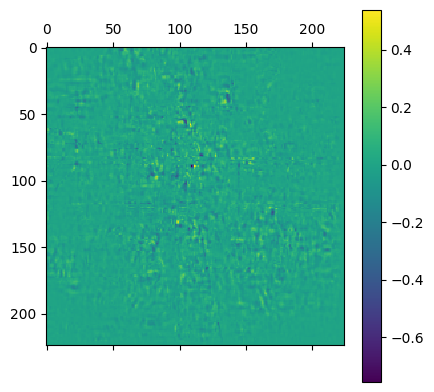

In [99]:
plt.matshow(normalized_maps.detach().cpu().numpy()[0])
plt.colorbar()
plt.show()

In [100]:
input = x.squeeze().detach().cpu().numpy().transpose(1, 2, 3, 0)
attribution_maps = normalized_maps.detach().cpu().numpy()
input.shape, attribution_maps.shape

((8, 224, 224, 3), (8, 224, 224))

In [134]:
def normalise(x):
    return (x - x.min()) / (x.max() - x.min())

def denormalize(frames, mean, std, dtype=np.float32):
    if type(mean) != np.ndarray:
        mean = np.array(mean)

    if type(std) != np.ndarray:
        std = np.array(std)

    frames = frames * np.array(std)[None, None, None, :] + np.array(mean)[None, None, None, :]
    if dtype == np.float32:
        return frames

    return np.uint8(frames)

def normalize_attributions(attribution_map):
    """
    Normalize attribution values to range [-1, 1]
    """
    abs_max = np.abs(attribution_map).max()
    if abs_max == 0:
        return attribution_map
    return attribution_map / abs_max

def create_color_overlay(attribution_map):
    """
    Create RGB overlay where:
    - Red channel represents negative attributions
    - Blue channel represents positive attributions
    - Intensity scales with attribution strength
    """
    # Initialize RGB array
    height, width = attribution_map.shape
    overlay = np.zeros((height, width, 3))

    # Separate positive and negative attributions
    pos_attr = np.maximum(0, attribution_map)
    neg_attr = np.abs(np.minimum(0, attribution_map))

    # Set red channel (negative attributions)
    overlay[:, :, 0] = neg_attr

    # Set blue channel (positive attributions)
    overlay[:, :, 2] = pos_attr

    return overlay

def visualize_attributions(attribution_map, original_image=None, alpha=0.5):
    """
    Create visualization of attribution map with color overlay.

    Parameters:
    -----------
    attribution_map : numpy.ndarray
        2D array of attribution values
    original_image : numpy.ndarray or None, optional
        Original image to overlay attributions on (should be in range [0,1])
    alpha : float, optional
        Transparency of the attribution overlay (0 to 1)

    Returns:
    --------
    numpy.ndarray
        RGB image with attribution overlay
    """
    # Normalize attribution values to [-1, 1]
    # normalized_map = normalize_attributions(attribution_map)

    # Create color overlay
    overlay = create_color_overlay(attribution_map)

    if original_image is not None:
        # Ensure original image is in range [0,1]
        if original_image.max() > 1:
            original_image = original_image / 255.0

        # Convert grayscale to RGB if necessary
        if len(original_image.shape) == 2:
            original_image = np.stack([original_image] * 3, axis=-1)

        # Blend original image with overlay
        visualization = (1 - alpha) * original_image + alpha * overlay
    else:
        visualization = overlay

    # Ensure output is in valid range [0,1]
    visualization = np.clip(visualization, 0, 1)

    return visualization

def generate_superpixels(x, size):
    h, w, *_ = x.shape
    result = np.zeros((h, w), dtype=np.int32)
    segment_value = 0

    for i in range(0, h, size):
        for j in range(0, w, size):
            result[i:i+size, j:j+size] = segment_value
            segment_value += 1

    return result


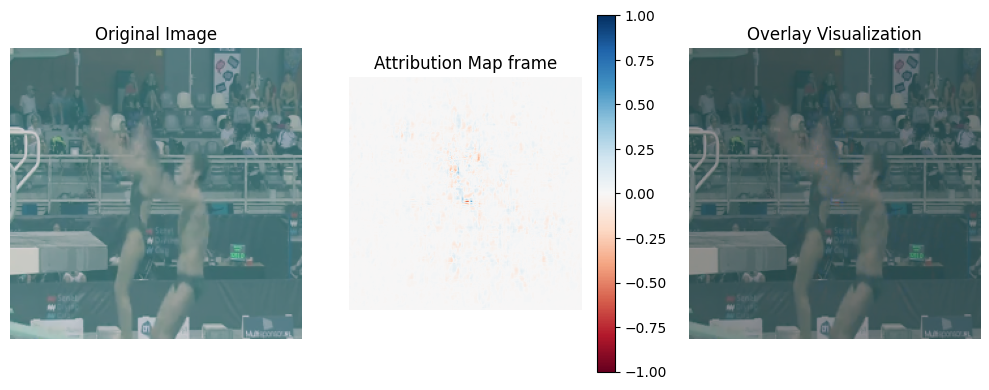

In [102]:
idx = 2
temp = input.copy()
temp = denormalize(temp, cfg.DATA.MEAN, cfg.DATA.STD)[idx]
attr_map = attribution_maps[idx]

viz = visualize_attributions(attr_map, original_image=temp, alpha=0.3)

plt.figure(figsize=(10, 4))
plt.subplot(131)
plt.title("Original Image")
plt.imshow(temp)
plt.axis('off')

plt.subplot(132)
plt.title(f"Attribution Map frame")
plt.imshow(attr_map, cmap='RdBu', label=f'mean = {np.mean(attr_map)}', vmin=-1, vmax=1)
plt.axis('off')
plt.colorbar()
plt.axis('off')


plt.subplot(133)
plt.title("Overlay Visualization")
plt.imshow(viz)
plt.axis('off')

plt.tight_layout()
plt.show()

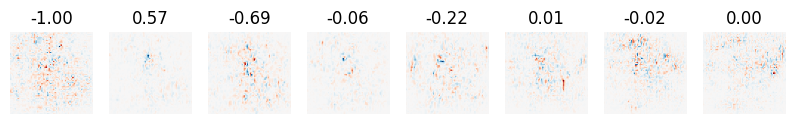

In [168]:
super_pixel_size = 4

def visualize_superpixel_mean(attribution_map, normalize=True):
    super_pixels = generate_superpixels(attribution_map, super_pixel_size)
    mean_attr = np.zeros_like(attribution_map)

    # average out the attributions per super pixel
    for i in range((super_pixels.shape[0] // super_pixel_size)**2):
        mean_attr[super_pixels == i] = np.mean(attribution_map[super_pixels == i])

    if normalize:
        return normalize_attributions(mean_attr)

    return mean_attr

def visualize_superpixel_frames(attribution_maps, normalize=True):
    return np.stack([visualize_superpixel_mean(attr_map, normalize=True) for attr_map in attribution_maps])


normalised_superpixels = visualize_superpixel_frames(attribution_maps, normalize=True)
frame_attr = attribution_maps.mean(axis=(1, 2))
abs_max = np.abs(frame_attr).max()
frame_attr = frame_attr / abs_max
plt.figure(figsize=(10, 4))
for i in range(181, 189):
    idx = abs(i - 181)
    mean_attr = normalised_superpixels[idx]
    plt.subplot(i)
    plt.title(f"{frame_attr[idx]:.2f}")
    plt.imshow(mean_attr, cmap='RdBu', vmin=-1, vmax=1)
    plt.axis('off')

plt.show()